### Numerical Part

#### N1:  Estimating the probability density of the level of the lake Huron

In [1]:
ts <- LakeHuron
options(repr.plot.width=5, repr.plot.height=4)

##### (i) Sturges rule

Construct the histogram estimator with the number of bins selected
by the Sturges rule. On the same plot display the graph of the density of the normal distribution with estimated mean and standard
deviation (normal fit).

In [2]:
nbins_sturges <- ceiling(log(length(ts), base = 2))
nbins_sturges

[1] 7

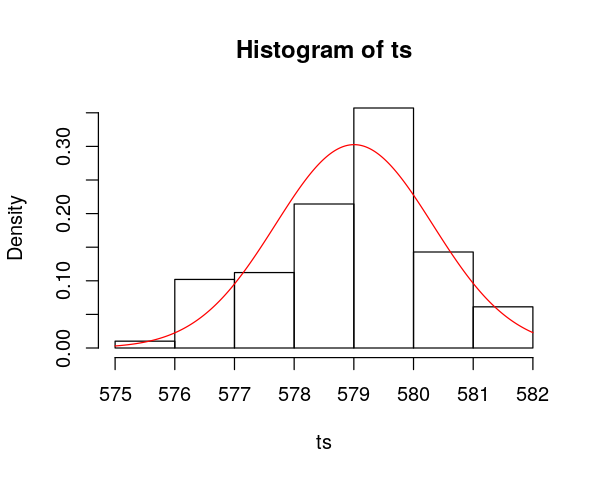

In [3]:
u <- seq(from = floor(min(ts)), to = ceiling(max(ts)), length = 1000)
hist(ts, breaks = "Sturges", freq = F)
lines(u, dnorm(u, mean = mean(ts), sd = sd(ts)), col = "red")

#####  (ii) Fitting to normal distribution

Among the histograms with the number of bins from 5 to 30, find
the histogram estimator which is closest to the normal fit. Comment on the bias-variance tradeoff in this case.

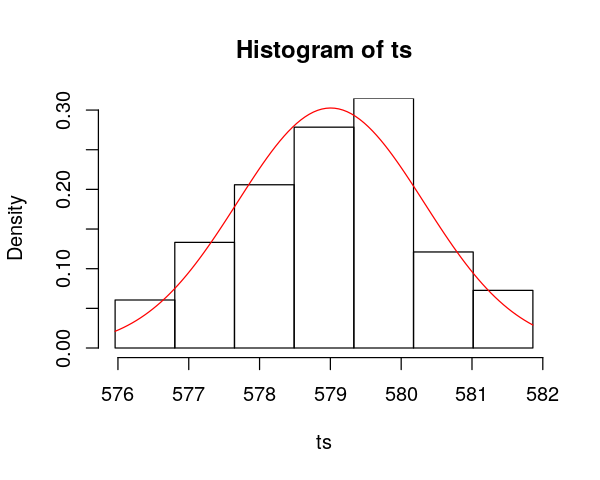

In [7]:
# because of pretty() there's no difference between several mse's that's why I
# use exact partitions of the interval
mse <- function(x) {
    u <- seq(min(ts), max(ts), l = x)
    H <- hist(ts, breaks = u, plot = F)
    pn <- sapply(u, function(z) {
        H$density[rev(which(H$breaks < z))[1]]
    })
    p <- dnorm(u, mean = mean(ts), sd = sd(ts))
    return(sum((pn - p)^2, na.rm = T))
}

brs <- 6:31 # (i-1) bins
res <- sapply(brs, mse)
br <- seq(min(ts), max(ts), l = brs[which.min(res)])
u <- seq(length = 100, from = min(ts), to = max(ts))
p <- dnorm(u, mean = mean(ts), sd = sd(ts))

hist(ts, breaks = br, freq = F, ylim = c(0, max(p)))
points(u, p, type = "l", col = "red")

The more bins we are using, the less bias the histogram has, but at the same moment the variance becomes larger:

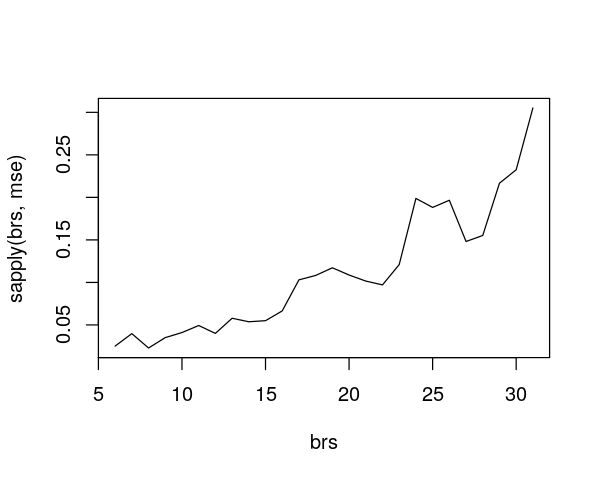

In [8]:
plot(brs, sapply(brs, mse), type='l')

##### (iii) Kernel estimation

Construct the kernel estimators with various kernels (apply all kernels available in the R language). The bandwidth can be chosen by
default. 

In [9]:
K <- eval(formals(density.default)$kernel)
K

[1] "gaussian"     "epanechnikov" "rectangular"  "triangular"   "biweight"    
[6] "cosine"       "optcosine"

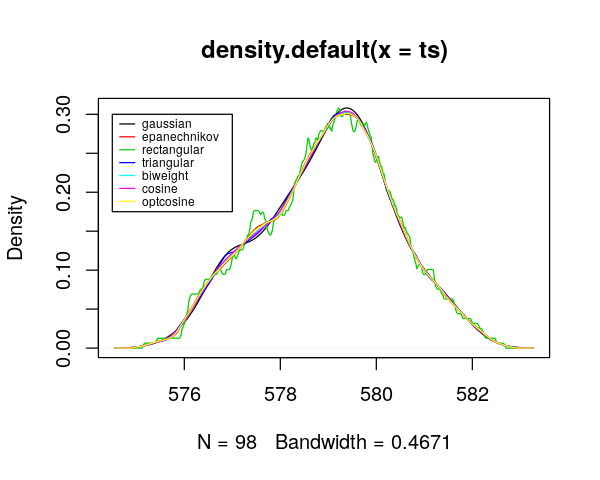

In [10]:
plot(density(ts))
for (i in 2:7) {
    lines(density(ts, kernel = K[i]), col = i)
}
legend(x = c(581 - 6.5, 583.5 - 6.5), y = c(0.25 + 0.05, 0.125 + 0.05), legend = K, 
    col = 1:7, cex = 0.6, lty = 1, y.intersp = 2)

Construct the kernel estimators under various choices of
bandwidth (apply all rules for bandwidth selection, which are implemented in the R language, the kernel can be chosen by default).

Warning message in bw.bcv(x):
“minimum occurred at one end of the range”

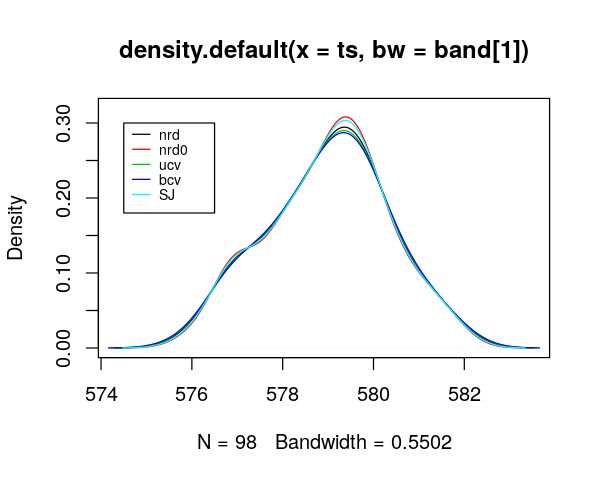

In [13]:
band <- c("nrd", "nrd0", "ucv", "bcv", "SJ")
plot(density(ts, bw = band[1]), ylim = c(0, 0.32))
for (i in 2:5) {
    lines(density(ts, bw = band[i]), col = i)
}

legend(x = c(581 - 6.5, 583 - 6.5), y = c(0.25 + 0.05, 0.13 + 0.05), legend = band, 
    col = 1:5, cex = 0.7, lty = 1, y.intersp = 2)

Among all constructed kernel estimators, find the kernel estimator
which is closest to the normal fit.

Warning message in bw.bcv(x):
“minimum occurred at one end of the range”Warning message in bw.bcv(x):
“minimum occurred at one end of the range”Warning message in bw.bcv(x):
“minimum occurred at one end of the range”Warning message in bw.bcv(x):
“minimum occurred at one end of the range”Warning message in bw.bcv(x):
“minimum occurred at one end of the range”Warning message in bw.bcv(x):
“minimum occurred at one end of the range”Warning message in bw.bcv(x):
“minimum occurred at one end of the range”Warning message in bw.bcv(x):
“minimum occurred at one end of the range”

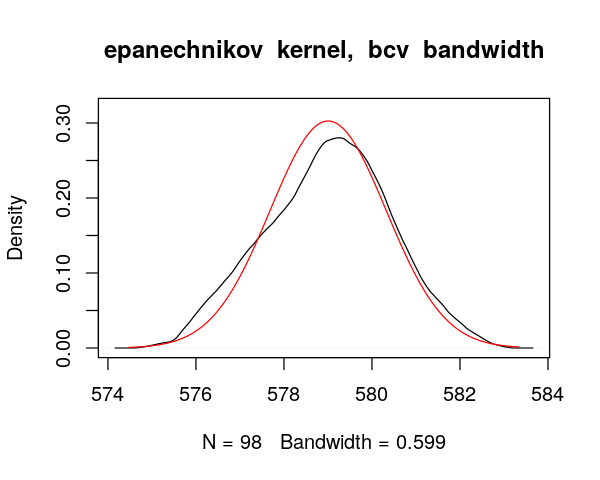

In [18]:
mse_list <- list()
for (i in 1:7) {
    mse <- c()
    for (j in 1:5) {
        D <- density(ts, kernel = K[i], bw = band[j])
        mse <- c(mse, mean((D$y - dnorm(D$x, mean = mean(ts), sd = sd(ts)))^2))
    }
    mse_list[[i]]  <- min(mse)
    mse_list[[i]][2]  <- band[which.min(mse)]
}
m <- which.min(sapply(mse_list, function(x) x[1]))
plot(density(ts, kernel = K[m], bw = sapply(mse_list, function(x) x[2])[m]), ylim = c(0, 
    0.32), main = (paste(K[m], " kernel, ", sapply(mse_list, function(x) x[2])[m], 
    " bandwidth")))
points(D$x, dnorm(D$x, mean = mean(ts), sd = sd(ts)), type = "l", col = "red")

#### N2: Simulating with given density

##### (i) Simulate a sample of length N = 1000:

Sample distribution with density:

$$ p(x) = 1/2 \phi^N (x) + 1/4 \phi^E (x + 1) + 1/4 \phi^E (-x + 1), x \in \mathbb{R}$$ 

where $\phi^N \sim N(0, 1)$, $\phi^E \sim Exp(1)$

In [19]:
n <- 1000

p_sim <- function(n) {
    eta <- sample(1:3, size = n, replace = TRUE, prob = c(0.5, rep(0.25, 2)))
    x <- rep(0, n)
    for (j in (1:n)) {
        if (eta[j] == 1) {
            x[j] <- rnorm(1, mean = 0, sd = 1)
        } else if (eta[j] == 2) {
            x[j] <- (rexp(1, rate = 1) - 1)
        } else if (eta[j] == 3) {
            x[j] <- (-rexp(1, rate = 1) + 1)
        }
    }
    return(x)
}

x  <- p_sim(n)

summary(x)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-3.80402 -0.69183 -0.06337 -0.02492  0.62158  7.62838 

##### (ii) Histogram estimator

Construct the histogram estimator  $\hat{p}_n(x)$ with number of bins chosen according to the Freedman-Diaconis rule. 

In [20]:
binwidth_fd  <-  2 * IQR(x) * (n)^{-1/3}
nbins_fd  <-  ceiling(diff(range(x))/binwidth_fd)
nbins_fd

[1] 44

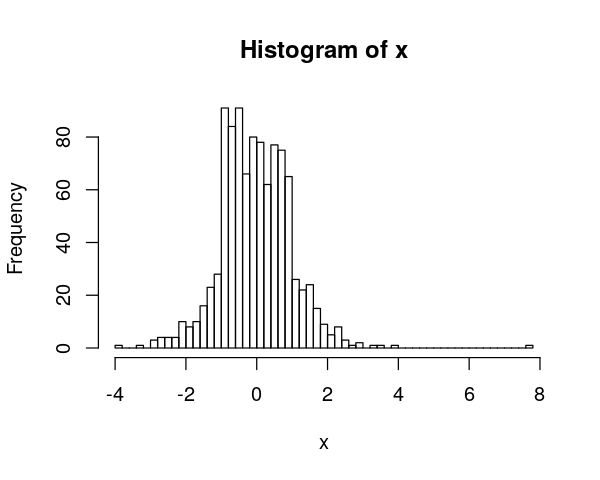

In [21]:
H <- hist(x, breaks = "FD")

Calculate the empirical analogue of MISE:

$$ MISE(\hat{p}_n ) = \frac{1}{Q}\sum^{Q}_{q=1}(\hat{p}_n (x_q) - p(x_q ))^2 $$

where $x_1, ..., x_Q$ form the equidistant grid on $[-3, 3]$, and $Q = 10000$.

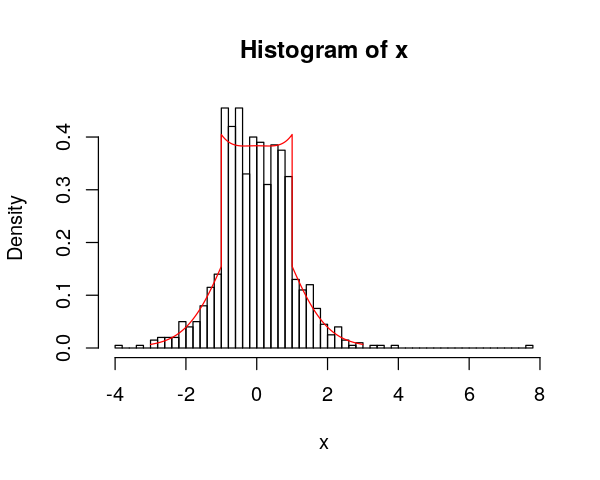

In [22]:
Q <- 10000
u <- seq(length = Q, from = -3, to = 3)
p  <-  function(x) {
    y = dnorm(x, mean = 0, sd = 1)/2 + ((dexp((x + 1), rate = 1))/4) +
    ((dexp((-x+1), rate = 1))/4)
    return(y)
}
plot(H, freq = F)
points(u, sapply(u, p), type = "l", col = "red")

In [23]:
mise <- function(u) {
    pnq <- sapply(u, function(z) {
        H$density[rev(which(H$breaks < z))[1]]
    })
    pq <- sapply(u, p)
    return(mean((pnq - pq)^2))
}

In [24]:
mise(u)

[1] 0.0008875429

##### (iii) Estimate MISE more precisely:
Repeat the steps 1 and 2 $J$ times, calculate the mean $MISE(\hat{p}_n (x))$ 

In [25]:
J  <-  100
mises  <- c()
for (i in 1:J) {
    x <- p_sim(n)
    H <- hist(x, breaks = "FD", plot = F)
    mises <- c(mises, mise(u))
}
mise_fd  <-  mean(mises, na.rm = T)
mise_fd

[1] 0.0007656796

##### (iv) Histogram estimator (alternative bandwidth):

Sturges rule:

In [26]:
sturges_const = ceiling(log(n, base=2))
sturges_const

[1] 10

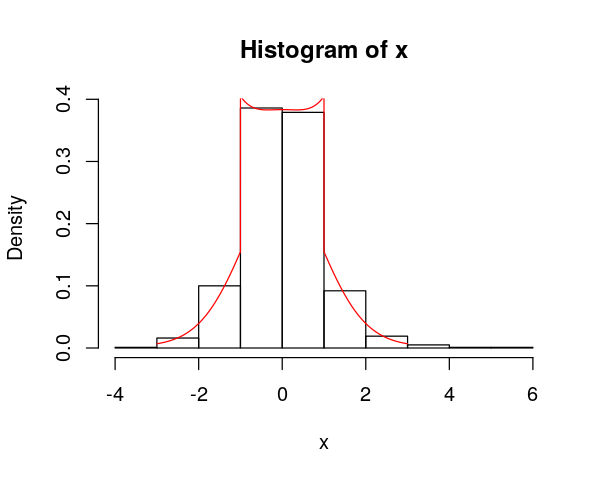

In [27]:
x <- p_sim(n)
H <- hist(x, breaks = "Sturges", plot = F)
plot(H, freq = F)
points(u, sapply(u, p), type = "l", col = "red")

In [28]:
mises  <- c()
for (i in 1:J) {
    x <- p_sim(n)
    H <- hist(x, breaks = "Sturges", plot = F)
    mises <- c(mises, mise(u))
}
mise_sturges  <-  mean(mises, na.rm = T)
mise_sturges

[1] 0.0008010921

Scott’s rules:

In [29]:
scott_const = ceiling(6/(3.5 * sd(x) / n^(1/3)))
scott_const

[1] 18

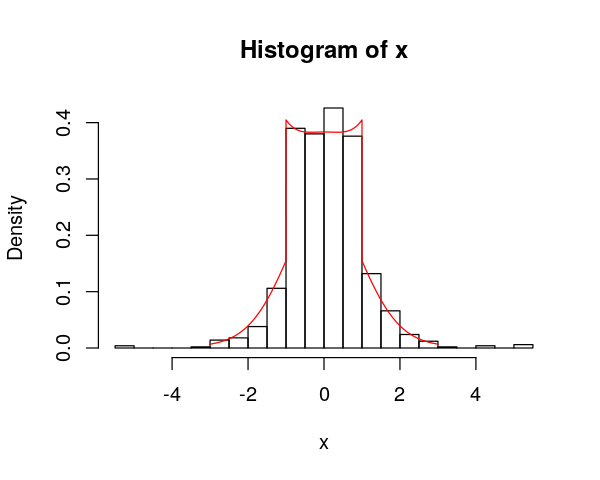

In [30]:
x <- p_sim(n)
H <- hist(x, breaks = "Scott", plot = F)
plot(H, freq = F)
points(u, sapply(u, p), type = "l", col = "red")

In [31]:
mises  <- c()
for (i in 1:J) {
    x <- p_sim(n)
    H <- hist(x, breaks = "Scott", plot = F)
    mises <- c(mises, mise(u))
}
mise_scott  <-  mean(mises, na.rm = T)
mise_scott

[1] 0.0003972913

In [32]:
best_rule <- c("FD", "Sturges", "Scott")[which.min(c(mise_fd, mise_sturges, mise_scott))]
cat('Bandwidth selection by', best_rule, 'rule gives the lowest MISE estimate on average.')

Bandwidth selection by Scott rule gives the lowest MISE estimate on average.

##### (v) Kernel estimator with Epanechnikov kernel

Consider the values of the bandwidth taking from an equidistant
grid on (0, 1) with step 0.01. For each value of bandwidth, construct
the kernel estimator with Epanechnikov kernel. Estimate the MISE
and plot the graph, which illustrates the dependence between h and
estimated MISE. Under which choice of h the MISE for the kernel
estimator is minimal?

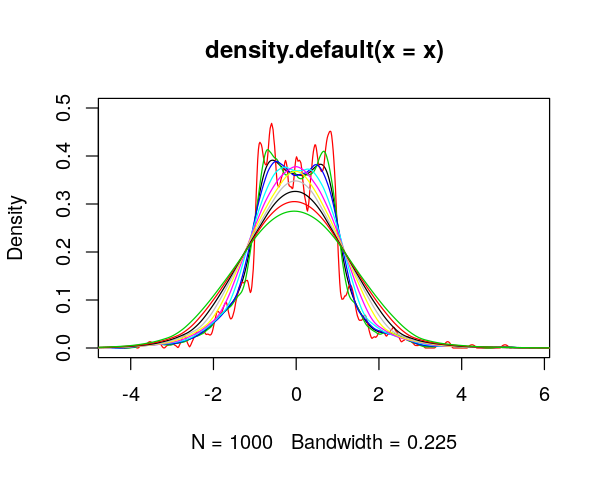

In [38]:
x <- p_sim(n)
plot(density(x), ylim=c(0,0.5))
band  <- seq(from = 0.05, to = 0.99, by = 0.1)
for (i in (1:length(band))) {
    lines(density(x, kernel = "epanechnikov", bw = band[i]), col = i+1)
}

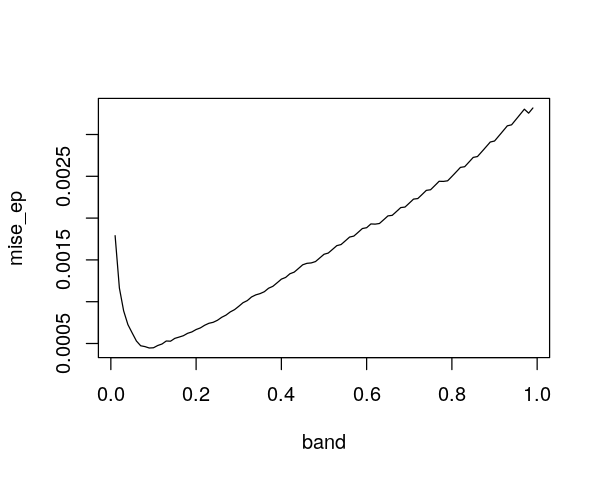

In [39]:
band <- seq(from = 0.01, to = 0.99, by = 0.01)
mise_ep <- c()
for (j in (1:length(band))) {
    D <- density(x, kernel = "epanechnikov", bw = band[j])
    mise_ep <- c(mise_ep, mean((D$y - sapply(D$x, p))^2))
}
plot(band, mise_ep, type = 'l')

In [40]:
opt_bw  <- band[which.min(mise_ep)] 
opt_bw

[1] 0.09

##### (vi) Plot

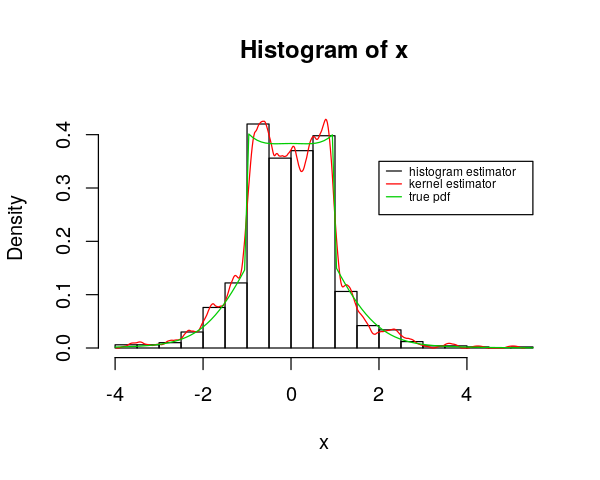

In [48]:
hist(x, breaks = best_rule, freq = F, ylim = c(0, 0.45))
lines(density(x, kernel = "epanechnikov", bw = opt_bw), col = 2)
curve(sapply(x, p), col = 3, add = TRUE, yaxt = "n")
legend(x = c(3.5-1.5, 5.5), y = c(0.25+0.1, 0.15+0.1),  legend = c("histogram estimator", "kernel estimator", "true pdf"), col = 1:3,  cex = 0.6, lty = 1,  y.intersp = 2)

### Theoretical part

#### T1 Boxcar kernel

$X_1 , ..., X_n \sim p(x)$ 

$(\hat{p})_n (x)$ - a kernel density estimator with the boxcar kernel:

$$K(x) = \mathbb{I}\{x \in [-1/2, 1/2]\}$$

##### (i) Mathematical expectation and the variance of  $\hat{p}_n (x)$

$\hat{p}_n(x) = \frac{1}{nh} \sum_{i=1}^n \mathbb{I} \{ |x-x_i| < h*1/2\} $

$E(\hat{p}_n(x)) = \frac{1}{nh} \sum_{i=1}^n E [\mathbb{I} \{ |x-x_i| < h/2\} ]  = \frac{1}{h}  E [\mathbb{I} \{ |x-X| < h/2 \} ]  =   \frac{1}{h}  P (|x-X| < h/2 )  = \frac{1}{h} ( F_X(x+h/2)-F_X(x-h/2))$

$Var(\hat{p}_n(x)) = \frac{1}{n^2h^2} \sum_{i=1}^n Var [\mathbb{I} \{ |x-x_i| < h/2\} ]  = \frac{1}{nh^2}  Var [\mathbb{I} \{ |x-X| < h/2 \} ]  =   \frac{1}{nh^2} ( E [\mathbb{I} \{ |x-X| < h/2 \} ]  - ( E [\mathbb{I} \{ |x-X| < h/2 \} ] )^2)  =  \frac{1}{nh^2} ( P (|x-X| < h/2 )   - (P (|x-X| < h/2 ) )^2) =  
  \frac{1}{nh^2} ( F_X(x+h/2)-F_X(x-h/2) - (F_X(x+h/2)-F_X(x-h/2))^2)$

##### (ii) Prove that the estimate is consistent

$\text{plim}_{n \to \infty} \hat{p}_n (x) = p_n (x), h \to  0, nh \to \infty$

$MSE(\hat{p}_n (x))  =  Var(\hat{p}_n (x)) + Bias(\hat{p}_n (x))^2$

$\lim_{n \to \infty}  E(\hat{p}_n(x)) =   \lim_{h_n \to 0} \frac{1}{h} ( F_X(x+h/2)-F_X(x-h/2)) = p(x) \Rightarrow Bias(\hat{p}_n (x))^2 = 0$

$\lim_{n \to \infty}  Var(\hat{p}_n(x)) = \lim_{n \to \infty}  \frac{1}{nh^2} ( F_X(x+h/2)-F_X(x-h/2) - (F_X(x+h/2)-F_X(x-h/2))^2)   = x)  = \lim_{n \to \infty}  \frac{p(x)}{nh}  = 0     \Rightarrow \lim_{n \to \infty} MSE(\hat{p}_n (x))  = 0  \Rightarrow consistency$


#### T2  $p(x)$ - a function defined by (1)

$$ p(x) = 1/2 \phi^N (x) + 1/4 \phi^E (x + 1) + 1/4 \phi^E (-x + 1), x \in \mathbb{R}$$ 

where $\phi^N \sim N(0, 1)$, $\phi^E \sim Exp(1)$

#####  (i) Explain why p(x) is the probability density function.

1. $p(x)$ positively defined $\forall x \in \mathbb{R}$

2. $\int_{-\infty }^{\infty } p(x)dx = \frac{1}{2} * 1 +   \frac{1}{4} * 1 + \frac{1}{4} * 1= 1$



##### (ii) Calculate mathematical expectation and variance of a random variable with this distribution.

$E(X) = \int_{-\infty }^{\infty } x  p(x)dx =  1/2 * 0 + 1/4 * 0 + 1/4 * 0 = 0$


$Var(X) = \int_{-\infty }^{\infty } x^2  p(x)dx =  1/2 * 1 + 1/4 * 1 + 1/4 * 1 = 1$


#### T3 Assume that the data follow $N(0,\sigma^2)$ 

##### (i) Calculate the optimal value of bandwidth of the histogram estimator

Calculate the value which minimizes the AMISE of the
histogram estimator:

$bias^2(\hat{p}_n(x)) =  1/4 * h^2 * \int p'(x)^2 dx  + 1/3 * h^2 * \int p'(x)^2 dx  - 1/2* h^2 *  \int p'(x)^2 dx  + O(h^3)=    \frac{h^2}{48 \sqrt{\pi } \sigma^3}  + O(h^3) $

$Var(\hat{p}_n(x)) =  1/(nh) * \int p(x)  + O(1/n) = 1/(nh) + O(1/n)$


$\text{arg}\min_{h^*} AMISE(\hat{p}_n(x)) =  \left( \frac{6}{n \int p'(x)^2 dx} \right)^{1/3} =  \left( \frac{6}{n * \frac{1}{4 \sqrt{\pi } \sigma^3}} \right)^{1/3} =   2 \sqrt[3]{3} \sqrt[6]{\pi } \sqrt[3]{\frac{\sigma^3}{n}} =  3.49083 \frac{\sigma}{\sqrt[3]{n}} $




##### (ii) Calculate the optimal value of bandwidth of the kernel estimator based on the normal kernel

$$ K(x) = \frac{1}{\sqrt{2 \pi}} e^{-x^2/2}$$ 



$bias^2(\hat{p}_n(x)) =  h^4/4 * (\int u^2 K(u) du)^2 * \int (p''(x)^2) * (1+o(1)) = \frac{3h^4}{32 \sqrt{\pi } \sigma^5} + O(h^5) $


$Var(\hat{p}_n(x)) =  1/(nh) * \int K^2 (u) du (1+o(1)) = \frac{1}{2\sqrt{\pi}nh} + O(1/n)$


$\text{arg}\min_{h^*} AMISE(\hat{p}_n(x)) =  \left( \frac{\int K(u)^2 du }{n *  \int K^2 (u) du * \int (p''(x))^2 dx} \right)^{1/5} =  \sigma * \left(  \frac{4}{3n  } \right)^{1/5} =  1.05922  \frac{\sigma}{\sqrt[5]{n}} $



##### (iii) Compare the results for the estimators:

- For kernel estimator bias is smaller (if $\sigma > 1$).

- For kernel estimator variance is smaller therefore error converges at a faster rate than for histogram estimator.


#### T4 Calculate the theoretical efficiencies 


$K_{ep}(x) = 3/4 (1-x^2) \mathbb{I} \{|x|<1\}  $

$K_{ep}^2(x) = 9/16 (1-x^2)^2 \mathbb{I} \{|x|<1\}  $

$\int K_{ep}^2(x) dx  =  \int_{-1}^1  9/16 * (1-x^2)^2  dx  = 3/5$

$\int x^2 K_{ep}(x) dx  =  \int_{-1}^1  3/4 * x^2 * (1-x^2)  dx  = 1/5$


$S(K_{ep}) = ((3/5)^2 * 1/5  )^{2/5} = 0.3491$

In [4]:
((3/5)^2 * 1/5)^(2/5)

[1] 0.3490865

##### (i) the boxcar kernel;

$ K(x) = 1/2 * \mathbb{I} \{|x|<1\} $

$ K^2_b (x) = 1/4 * \mathbb{I} \{|x|<1\} $

$\int K_{b}^2(x) dx  =  \int_{-1}^1  1/4  dx  = 1/2$

$\int x^2 K_{b}(x) dx  =  \int_{-1}^1  1/2 * x^2  dx  = 1/3$


$s(K_{b}) = ((1/2)^2 * 1/3  )^{2/5} = 0.3701$

$$Eff(K_b) =\left(\frac{S(K_{ep})}{S(K_{b})}\right)^{5/4} =  0.929516$$

In [7]:
((((3/5)^2 * 1/5)^(2/5))/(((1/2)^2 * 1/3)^(2/5)))^(5/4)

[1] 0.929516

##### (ii) the Gaussian kernel.

$ K(x) = \frac{1}{\sqrt{2 \pi}} e^{-x^2/2}$ 

$ K^2_g (x) = \frac{1}{2 \pi} e^{-x^2}$

$\int K_{g}^2(x) dx  =  \int_{-\infty}^{\infty} \frac{1}{2 \pi} e^{-x^2} dx  = \frac{1}{2 \sqrt{\pi}} $

$\int x^2 K_{g}(x) dx  =  \int_{-\infty}^{\infty}   x^2 * \frac{1}{\sqrt{2 \pi}} e^{-x^2/2}  dx  = 1$


$s(K_{g}) = (\frac{1}{2 \sqrt{\pi}} )^{4/5} = 0.363342$

$$Eff(K_g) =\left(\frac{S(K_{ep})}{S(K_{g})}\right)^{5/4} =  0.951198$$


In [10]:
((((3/5)^2 * 1/5)^(2/5) )/ ((1/(2 * sqrt(pi)))^(4/5)))^(5/4)

[1] 0.9511986